### loading model

In [19]:
# Imports here
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import time
from PIL import Image
import copy
import json

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")
print(device)

cpu


In [21]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [22]:
# TODO: Write a function that loads a checkpoint and rebuilds the model

device = torch.device(device)
# TODO: Write a function that loads a checkpoint and rebuilds the model
def load_checkpoint(filepath):
    if torch.cuda.is_available():
        map_location=lambda storage, loc: storage.cuda()
    else:
        map_location='cpu'

    checkpoint = torch.load(filepath, map_location=map_location)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    model.class_to_idx = checkpoint['class_to_idx']
    optimizer = checkpoint['optimizer']
    epochs = checkpoint['epochs']
    batch_size = checkpoint['batch_size']
    for param in model.parameters():
        param.requires_grad = False
        
    return model, checkpoint['class_to_idx']


In [23]:
model, class_to_idx = load_checkpoint('checkpoint_vgg.pth')

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [24]:
def load_image(path, image_size = (224,224)):
    image = Image.open(path)
    preprocess = transforms.Compose([transforms.Resize(image_size),
                                                transforms.CenterCrop(image_size),
                                                transforms.ToTensor(),
                                                transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))
                                                ])
    processed_image = preprocess(image)
    return image, processed_image

In [25]:
def predict(image, model, topk=5):
    image = image.unsqueeze(0)
    model.eval()
    if torch.cuda.is_available():
        model.cuda()
    inputs = image.to(device)
    logits = model.forward(inputs)
    
    ps = F.softmax(logits,dim=1)
    topk = ps.cpu().topk(topk)
    
    return (e.data.numpy().squeeze().tolist() for e in topk)
    

In [26]:
def view_classify(img_path, prob, classes, mapping):
    image = Image.open(img_path)
    fig, (ax1, ax2) = plt.subplots(figsize=(6,10), ncols=1, nrows=2)
    flower_name = class_list[0]
    ax1.set_title(flower_name)
    ax1.imshow(image)

    
    y_pos = np.arange(len(prob))
    ax2.barh(y_pos, prob, align='center')
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(class_list)
    ax2.invert_yaxis()  # labels read top-to-bottom
    ax2.set_title('Class Probability')

In [27]:
image_path = "flowers/test/21/image_06805.jpg"
image_size = (224,224)
image, processed_image = load_image(image_path,image_size ) 

In [28]:
probs, classes = predict(processed_image, model)
print(probs)
print(classes)

[0.9590977430343628, 0.014229615218937397, 0.010492425411939621, 0.0029614923987537622, 0.001845913240686059]
[16, 85, 80, 33, 12]


In [29]:
class_list = []
for class_ in classes:
    num = str(class_)
    class_list.append(cat_to_name.get(num))

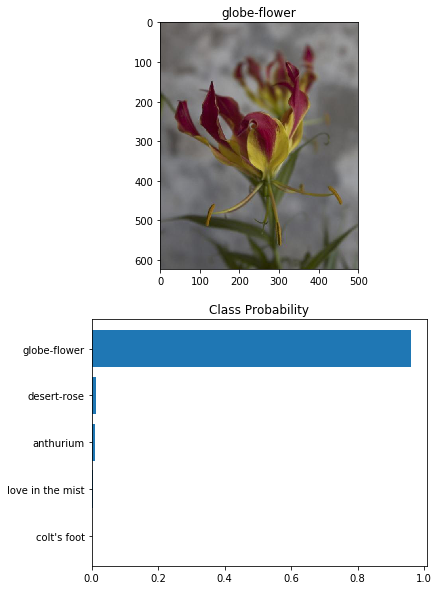

In [30]:
view_classify(image_path, probs, class_list, cat_to_name)

In [161]:
probs, classes = predict(processed_image, model)